<a href="https://colab.research.google.com/github/TayYuanGeng/SC3000/blob/main/Lab%201.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab Assignment 1

## Installing dependencies:

In [41]:
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install 'gymnasium[classic_control]'
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install moviepy > /dev/null 2>&1

## Importing dependencies and define helper functions

In [42]:
import gym
from gym import logger as gymlogger
from gym.wrappers import RecordVideo
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML
from IPython import display as ipythondisplay
from collections import defaultdict # Used for training agent

gymlogger.set_level(40) #show error only

def condense_rewards(rewards, group_size=5000):
    return [np.mean(rewards[i:i + group_size]) for i in range(0, len(rewards), group_size)]

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else:
    print("Could not find video")

## Loading CartPole environment

In [43]:
env = gym.make("CartPole-v1")

We can check the action and observation space of this environment. Discrete(2) means that there are two valid discrete actions: 0 & 1.

In [44]:
print(env.action_space)

Discrete(2)


The observation space is given below. The first two arrays define the min and max values of the 4 observed values, corresponding to cart position, velocity and pole angle, angular velocity.

In [45]:
print(env.observation_space)

Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)


In [46]:
observation = env.reset()
print("Initial observations:", observation)

Initial observations: [ 0.01799272  0.00974587  0.01706881 -0.02532084]


## Task 1: Development of Q-Learning Agent

Development of an RL agent. Demonstrate the correctness of the implementation by sampling a random state from the cart pole environment, inputting to the agent, and outputting a chosen action. Print the values of the state and chosen action in Jupyter notebook.

## Q-Learning Implementation
- Epsilon Decay: Epsilon is gradually reduced during training to balance exploration and exploitation. Early in training, a higher epsilon value encourages exploration, allowing the agent to gather diverse experiences. As training progresses, epsilon decreases to favor exploitation, maximizing rewards based on learned knowledge. A minimum threshold is set to prevent epsilon from reaching zero.
- Learning Rate Decay: The learning rate starts high to facilitate larger updates towards optimal solutions. As training progresses, it decays to ensure smaller, more precise updates, preventing overshooting of the optimal values.

## Selecting Optimal Action
- The agent selects action that maximizes the Q-value from the **Q-table**.
- It evaluates all possible actions for the current state and returns the one with the highest Q-value.
- An **epsilon-soft policy** is applied, where the agent occasionally selects a random action based on the current epsilon value to maintain exploration.

## Q-Table Update Formula
- Q-table is updated following the standard Q-learning formula from lecture materials.
- This update helps refine the action-value estimates over time, improving decision-making.

## State Space Representation
- The state space is discretized using bins to handle continuous variables such as cart position, velocity, pole angle, and angular velocity.
- The **num_bins** parameter determines the granularity of this discretization, ensuring an effective mapping of continuous states to discrete values.

In [59]:
class QLAgent:
    def __init__(self, env, num_bins=(30, 30, 30, 30), alpha=0.5, alpha_min=0.1, alpha_decay=0.99999,
                 gamma=0.99, epsilon=0.9, epsilon_min=0.01, epsilon_decay=0.9999, num_train_episodes=30000):
        self.env = env
        self.num_bins = num_bins
        self.alpha = alpha
        self.alpha_min = alpha_min
        self.alpha_decay = alpha_decay
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_decay = epsilon_decay
        self.num_train_episodes = num_train_episodes

        self.state_bounds = list(zip(env.observation_space.low, env.observation_space.high))
        self.state_bounds[1] = (-3, 3)  # Fix bounds for cart velocity
        self.state_bounds[3] = (-10, 10)  # Fix bounds for pole angular velocity

        self.Q = defaultdict(lambda: np.random.uniform(0, 1, env.action_space.n))
        self.train_rewards = []

    def discretize_state(self, state):
        """ Convert continuous state into a discrete tuple """
        state = np.clip(state, self.env.observation_space.low, self.env.observation_space.high)
        ratios = [(state[i] - self.state_bounds[i][0]) / (self.state_bounds[i][1] - self.state_bounds[i][0])
                  for i in range(len(state))]
        discrete_state = [int(ratio * (self.num_bins[i] - 1)) for i, ratio in enumerate(ratios)]
        return tuple(discrete_state)

    def epsilon_greedy_policy(self, state):
        """ Selects action using epsilon-greedy policy """
        if random.uniform(0, 1) < self.epsilon:
            return self.env.action_space.sample()  # Explore
        else:
            return np.argmax(self.Q[state])  # Exploit best-known action

    def train(self):
        for episode in range(self.num_train_episodes):
            state = self.discretize_state(self.env.reset()[0]) # Reset to a randomized initial state
            done = False
            total_reward = 0
            step_count = 0

            if episode > 5000:
                self.epsilon = max(self.epsilon_min, self.epsilon * 0.99999)

            while not done:
                action = self.epsilon_greedy_policy(state)
                next_state, reward, done, info = self.env.step(action)
                step_count += 1
                if step_count >= 500:
                    done = True

                next_state = self.discretize_state(next_state)

                # Q-learning update
                self.Q[state][action] += self.alpha * (reward + self.gamma * np.max(self.Q[next_state]) - self.Q[state][action])

                state = next_state
                total_reward += reward

            self.train_rewards.append(total_reward)

            # Decay epsilon and alpha gradually
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            self.alpha = max(self.alpha_min, self.alpha * self.alpha_decay)

            # # Print progress every 1000 episodes
            # if episode % 1000 == 0:
            #     print(f"Episode {episode}: Avg Reward (last 100) = {np.mean(self.train_rewards[-100:])}")

        return self.Q

    def evaluate(self, num_eval_episodes=100, record=False, video_folder="./video"):
        """Evaluates the trained agent, optionally recording a video of the first episode."""
        eval_rewards = []
        env = gym.make("CartPole-v1", render_mode="rgb_array")

        if record:
            env = RecordVideo(env, video_folder, episode_trigger=lambda episode_id: episode_id == 0)

        for episode in range(num_eval_episodes):
            state = self.discretize_state(env.reset()[0])
            done = False
            total_reward = 0
            step_count = 0

            while not done:
                action = np.argmax(self.Q[state])  # Always exploit best action
                next_state, reward, done, info = env.step(action)
                step_count += 1
                if step_count >= 500:
                    done = True

                next_state = self.discretize_state(next_state)
                state = next_state
                total_reward += reward

            eval_rewards.append(total_reward)

        env.close()
        return eval_rewards

##Fine Tuning of Q-Learning Agent (Minimum Learning Rate)
We will have to fine tune the minimum learning rate **alpha_min**, via observing the agent's learning progress and the rate of improvement in rewards and performance over 30000 episodes. This will let us find the optimal minimum learning rate for the agent.

Below is the graphs of Q-Learning agent with minimum learning rate of 0.01.

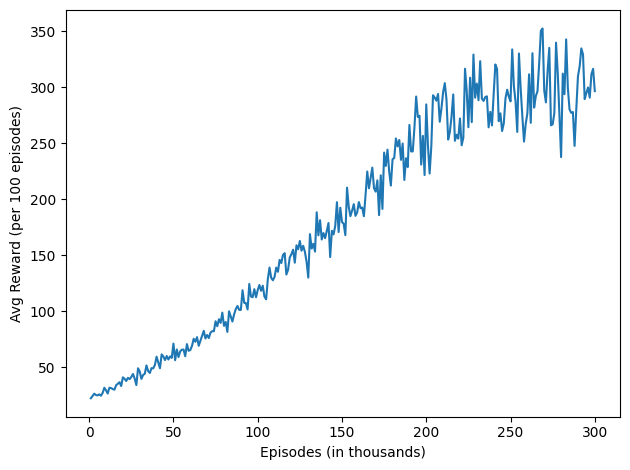

In [61]:
agent = QLAgent(env, alpha_min=0.01)
Q_table = agent.train()

smoothed_rewards = condense_rewards(agent.train_rewards, group_size=100)

fig, ax = plt.subplots()
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards)

ax.set_ylabel('Avg Reward (per 100 episodes)')
ax.set_xlabel('Episodes (in thousands)')

plt.tight_layout()

plt.show()

From the above, we observed that the agent performs poorly as the rewards fluctuate consistently between 250 to 350 towards the end but rewards did not exceed 350.

We will now set to a higher minimum learning rate, 0.05.

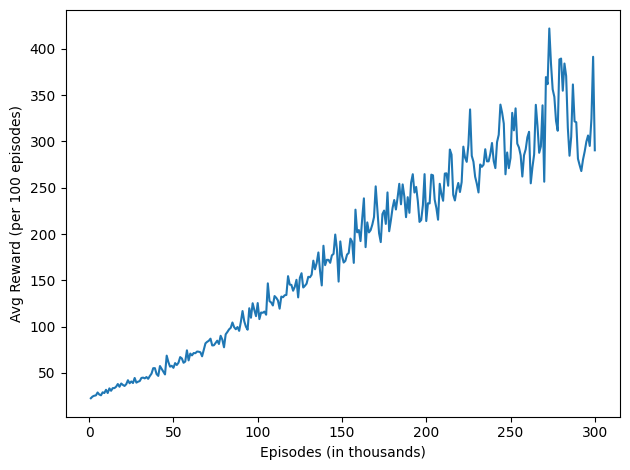

In [62]:
agent = QLAgent(env, alpha_min=0.05)
Q_table = agent.train()

smoothed_rewards = condense_rewards(agent.train_rewards, group_size=100)

fig, ax = plt.subplots()
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards)

ax.set_ylabel('Avg Reward (per 100 episodes)')
ax.set_xlabel('Episodes (in thousands)')

plt.tight_layout()

plt.show()

From the above, we observed that the agent performs better in terms of the average reward as compared to minimum learning rate of 0.01 but the rewards fluctuate alot.

We will now try increasing to a higher minimum learning rate, 0.1.

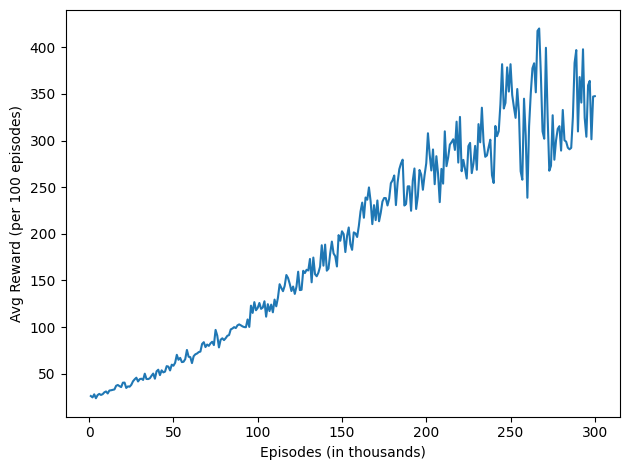

In [63]:
agent = QLAgent(env, alpha_min=0.1)
Q_table = agent.train()

smoothed_rewards = condense_rewards(agent.train_rewards, group_size=100)

fig, ax = plt.subplots()
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards)

ax.set_ylabel('Avg Reward (per 100 episodes)')
ax.set_xlabel('Episodes (in thousands)')

plt.tight_layout()

plt.show()

From the above, we observed that the agent performs better than the previous 2 minimum learning rate and the reward values are fluctuating between 300 to 400 towards the end.

We can stop testing since we are finding for the minimum learning rate, this can also avoid agent from adapting too slowly and memorizing experiences instead of generalizing them.

We will fix the minimum learning rate to **0.1** and fine tune the epsilon on the next section

##Fine Tuning of Q-Learning Agent (Epsilon)
We will have to fine tune **epsilon**. Similar to minimum learning rate, we will observe the agent's learning progress and the rate of improvement in rewards and performance over 30000 episodes. This will let us find the optimal minimum learning rate for the agent.

Below is the graphs of Q-Learning agent with epsilon of 0.4.

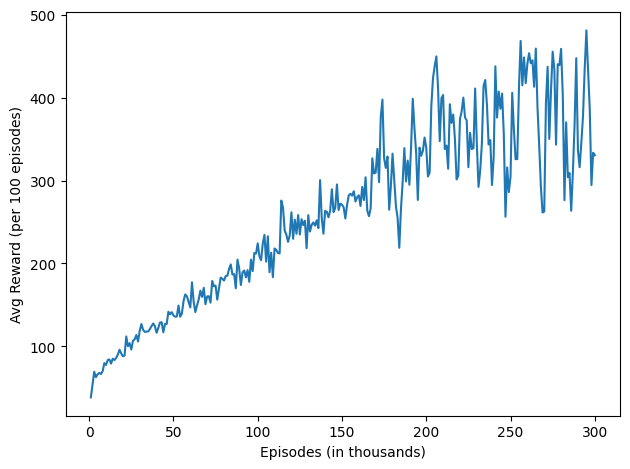

In [64]:
agent = QLAgent(env, epsilon=0.4)
Q_table = agent.train()

smoothed_rewards = condense_rewards(agent.train_rewards, group_size=100)

fig, ax = plt.subplots()
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards)

ax.set_ylabel('Avg Reward (per 100 episodes)')
ax.set_xlabel('Episodes (in thousands)')

plt.tight_layout()

plt.show()

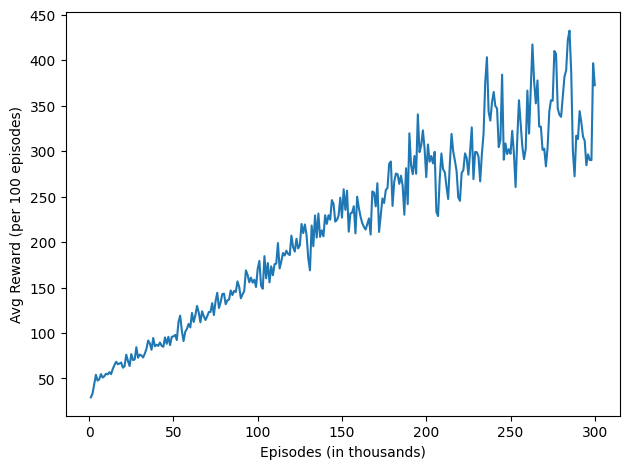

In [65]:
agent = QLAgent(env, epsilon=0.6)
Q_table = agent.train()

smoothed_rewards = condense_rewards(agent.train_rewards, group_size=100)

fig, ax = plt.subplots()
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards)

ax.set_ylabel('Avg Reward (per 100 episodes)')
ax.set_xlabel('Episodes (in thousands)')

plt.tight_layout()

plt.show()

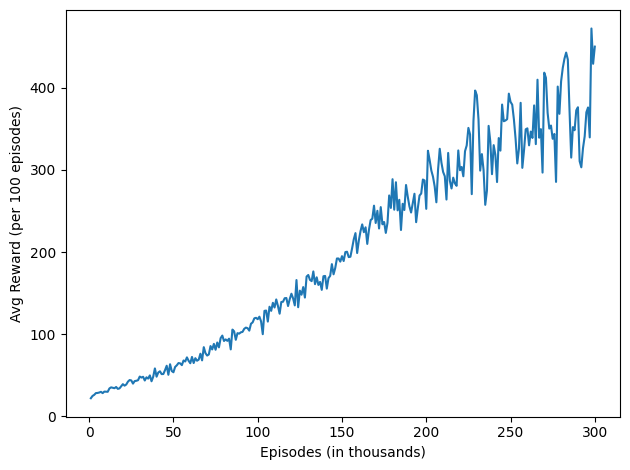

In [66]:
agent = QLAgent(env, epsilon=0.9)
Q_table = agent.train()

smoothed_rewards = condense_rewards(agent.train_rewards, group_size=100)

fig, ax = plt.subplots()
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards)

ax.set_ylabel('Avg Reward (per 100 episodes)')
ax.set_xlabel('Episodes (in thousands)')

plt.tight_layout()

plt.show()

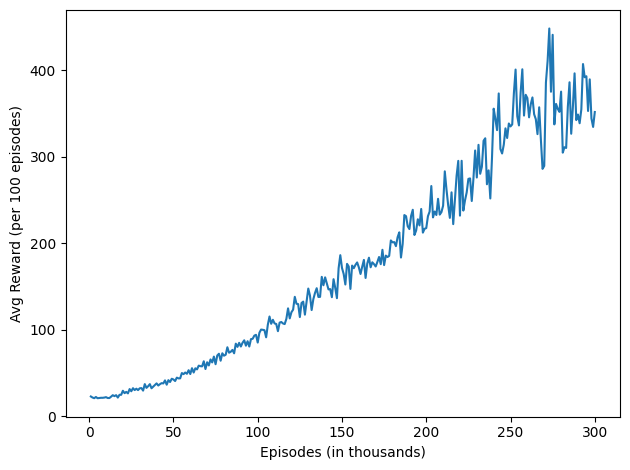

In [67]:
agent = QLAgent(env, epsilon=1.1)
Q_table = agent.train()

smoothed_rewards = condense_rewards(agent.train_rewards, group_size=100)

fig, ax = plt.subplots()
plt.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards)

ax.set_ylabel('Avg Reward (per 100 episodes)')
ax.set_xlabel('Episodes (in thousands)')

plt.tight_layout()

plt.show()

From the above, we observed that out of all the epsilon, setting it **1.1** produces a result where average reward generally fluctuate between 300 to 400 and is stable towards the end.

## Task 2: Demonstrate the effectiveness of the RL agent

Demonstrate the effectiveness of the RL agent. Run for 100 episodes (reset the environment at the beginning of each episode) and plot the cumulative reward against all episodes in Jupyter. Print the average reward over the 100 episodes. The average reward should be larger than 195.

In [68]:
agent = QLAgent(env, epsilon=1.1, alpha_min=0.1)
Q_table = agent.train()

eval_rewards = agent.evaluate(record=True)

/usr/local/lib/python3.11/dist-packages/gym/utils/passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


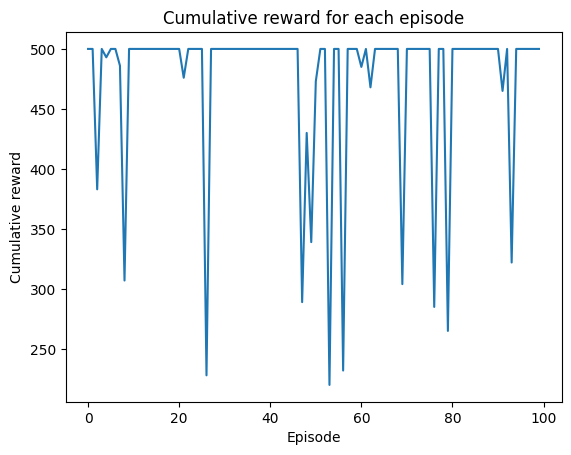

In [69]:
# Plot the cumulative rewards
plt.plot(eval_rewards)
plt.title('Cumulative reward for each episode')
plt.ylabel('Cumulative reward')
plt.xlabel('Episode')
plt.show()

Print the average reward over the 100 episodes.

In [70]:
print("Average cumulative reward:", np.mean(eval_rewards))
print("Is my agent good enough?", np.mean(eval_rewards) > 195)

Average cumulative reward: 474.5
Is my agent good enough? True


## Task 3: Render one episode played by the agent

In [71]:
show_video()